In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("MNIST dataset loaded successfully.")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


MNIST dataset loaded successfully.
Training samples: 60000
Test samples: 10000


In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = .25

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        # avg_probs = torch.mean(encodings, dim=0)
        # perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), loss#, perplexity, encodings


In [8]:
class ConvEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x):
        return self.conv_encoder(x)

class ConvDecoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_dim, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.conv_decoder(z)


class VQVAE(nn.Module):
    def __init__(self, input_dim, num_embeddings, embedding_dim):
        super().__init__()
        self.encoder = ConvEncoder(input_dim)
        self.codebook = VectorQuantizer(num_embeddings, embedding_dim)
        self.decoder = ConvDecoder(input_dim)

    def forward(self, x):
        z = self.encoder(x)
        z_quantized, vq_loss = self.codebook(z)
        x_reconstructed = self.decoder(z_quantized)
        return x_reconstructed, z_quantized, vq_loss

In [9]:
def loss_function(x_reconstructed, x, vq_loss):
    BCE = F.binary_cross_entropy(x_reconstructed, x, reduction='mean')
    return BCE + vq_loss    

v = VQVAE(input_dim=1, num_embeddings=500, embedding_dim=16).to(device)
optimizer = optim.Adam(v.parameters(), lr=1e-4)

In [10]:
def train(epoch):
    v.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstructed, z_quantized, vq_loss = v(data)
        loss = loss_function(x_reconstructed, data, vq_loss)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"====> Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset)}")

def test():
    v.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            x_reconstructed, z_quantized, vq_loss = v(data)
            x_reconstructed = torch.clamp(x_reconstructed, 0, 1)  # Ensure values are between 0 and 1
            test_loss += loss_function(x_reconstructed, data, vq_loss).item()
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")

for epoch in range(1, 50):
    train(epoch)
    test()  # Added test() call after each epoch


====> Epoch 1 Average loss: 0.0757720969637235
====> Test set loss: 0.0588
====> Epoch 2 Average loss: 0.021529365118344624
====> Test set loss: 0.0115
====> Epoch 3 Average loss: 0.013916484882434209
====> Test set loss: 0.0161
====> Epoch 4 Average loss: 0.013683316765228907
====> Test set loss: 0.0117
====> Epoch 5 Average loss: 0.00962685266137123
====> Test set loss: 0.0086
====> Epoch 6 Average loss: 0.007166761526465416
====> Test set loss: 0.0063
====> Epoch 7 Average loss: 0.0052371575772762295
====> Test set loss: 0.0046
====> Epoch 8 Average loss: 0.003976958028475443
====> Test set loss: 0.0036
====> Epoch 9 Average loss: 0.0030932358831167223
====> Test set loss: 0.0028
====> Epoch 10 Average loss: 0.002529175953567028
====> Test set loss: 0.0023
====> Epoch 11 Average loss: 0.0021327169371147953
====> Test set loss: 0.0020
====> Epoch 12 Average loss: 0.0018664948994914692
====> Test set loss: 0.0018
====> Epoch 13 Average loss: 0.00167807501728336
====> Test set loss: 0.

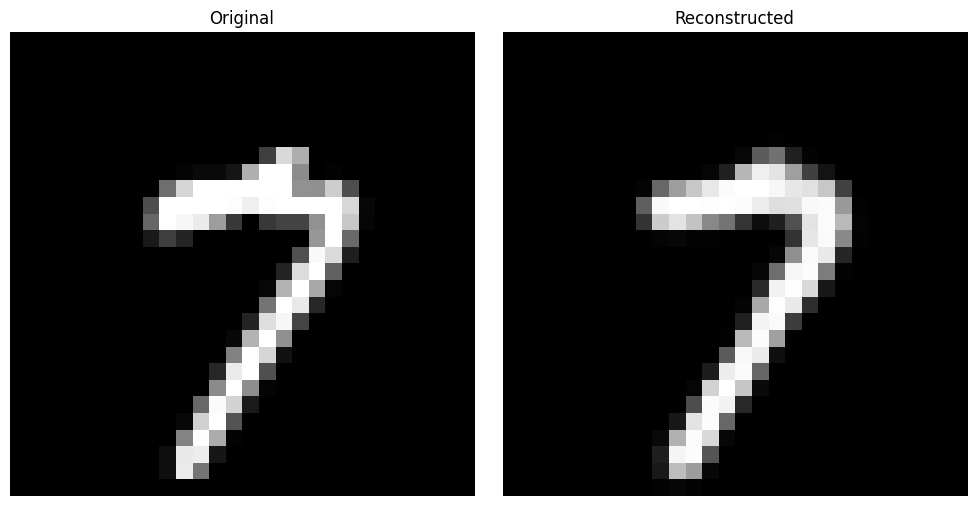

In [44]:
# Generate and display a reconstructed image
v.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Get a random batch of test data
    random_idx = torch.randint(0, len(test_loader.dataset), (1,)).item()
    test_data = test_loader.dataset[random_idx][0].unsqueeze(0).to(device)
    
    # Generate a reconstruction
    x_reconstructed, _, _ = v(test_data)
    
    # Ensure the values are between 0 and 1
    x_reconstructed = torch.clamp(x_reconstructed, 0, 1)
    
    # Convert to numpy arrays for plotting
    original = test_data[0].cpu().numpy().reshape(28, 28)
    reconstructed = x_reconstructed[0].cpu().numpy().reshape(28, 28)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the original image
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    
    # Plot the reconstructed image
    ax2.imshow(reconstructed, cmap='gray')
    ax2.set_title('Reconstructed')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


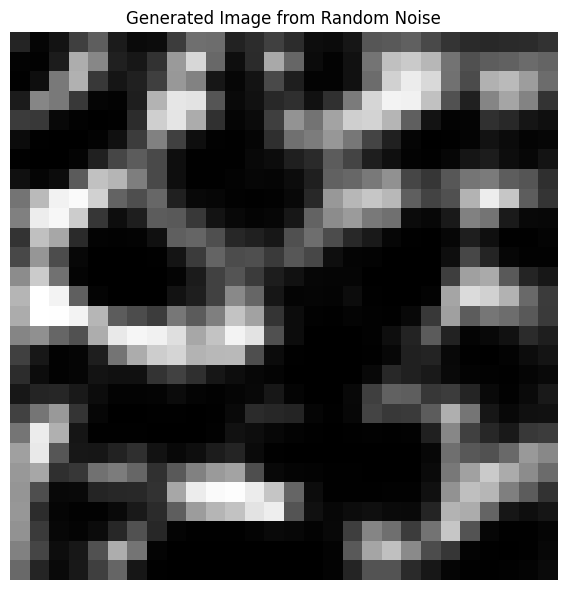

In [34]:
# Generate an image from a random noise vector
v.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Generate a random noise vector
    z = torch.randn(1, 64, 4, 4).to(device)
    
    # Generate an image from the noise vector
    generated_image = v.decoder(z)
    
    # Ensure the values are between 0 and 1
    generated_image = torch.clamp(generated_image, 0, 1)
    
    # Convert to numpy array for plotting
    generated_image = generated_image[0].cpu().numpy().reshape(28, 28)

    # Create a figure
    plt.figure(figsize=(6, 6))
    
    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.title('Generated Image from Random Noise')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
